In [2]:
%pip install pandas scikit-learn numpy matplotlib seaborn memory_profiler setuptools

Note: you may need to restart the kernel to use updated packages.


In [1]:
%load_ext memory_profiler

In [15]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, mutual_info_classif
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.errors import SettingWithCopyWarning
import warnings
import matplotlib.pyplot as plt
from sklearn.svm import SVC
warnings.simplefilter('ignore', SettingWithCopyWarning)

In [16]:
cols = [ 'Day of the week', 'Day of the week_sin', 'Day of the week_cos', 'CarCount', 'BikeCount', 'BusCount', 'Traffic Situation', 'Minute_sin', 'Minute_cos', 'Hour_sin', 'Hour_cos', 'IsDay' ]
data = pd.read_csv('./data/raw.csv', index_col=0)[cols]
data.head()

features = data.drop(columns=['Traffic Situation'])
target = data['Traffic Situation']

train_size = int(0.8 * len(data))
X_train, X_test = features[:train_size], features[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

In [17]:
cols=['CarCount', 'BikeCount', 'BusCount']
scaler = StandardScaler()

scaler.fit(X_train[cols])
X_train[cols] = scaler.transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

In [18]:
lags = 4
lag_cols=['CarCount', 'BikeCount', 'BusCount']
for col in lag_cols:
    for lag in range(1, lags+1):
        X_train[f'{col}_lag{lag}'] = X_train[col].shift(lag)
        X_test[f'{col}_lag{lag}'] = X_test[col].shift(lag)

X_train = X_train.iloc[lags:]
y_train = y_train.iloc[lags:]
X_test = X_test.iloc[lags:]
y_test = y_test.iloc[lags:]


features - ['CarCount']
features - ['CarCount' 'BusCount']
features - ['CarCount' 'BusCount' 'CarCount_lag1']
features - ['CarCount' 'BikeCount' 'BusCount' 'CarCount_lag1']
features - ['CarCount' 'BikeCount' 'BusCount' 'Hour_cos' 'CarCount_lag1']
features - ['CarCount' 'BikeCount' 'BusCount' 'Hour_cos' 'CarCount_lag1'
 'CarCount_lag2']
features - ['CarCount' 'BikeCount' 'BusCount' 'Hour_cos' 'CarCount_lag1'
 'CarCount_lag2' 'CarCount_lag3']
features - ['CarCount' 'BikeCount' 'BusCount' 'Hour_cos' 'CarCount_lag1'
 'CarCount_lag2' 'CarCount_lag3' 'BikeCount_lag1']
features - ['CarCount' 'BikeCount' 'BusCount' 'Hour_cos' 'CarCount_lag1'
 'CarCount_lag2' 'CarCount_lag3' 'BikeCount_lag1' 'BusCount_lag1']
features - ['CarCount' 'BikeCount' 'BusCount' 'Hour_cos' 'CarCount_lag1'
 'CarCount_lag2' 'CarCount_lag3' 'BikeCount_lag1' 'BikeCount_lag2'
 'BusCount_lag1']
features - ['CarCount' 'BikeCount' 'BusCount' 'Hour_cos' 'CarCount_lag1'
 'CarCount_lag2' 'CarCount_lag3' 'CarCount_lag4' 'BikeCount_

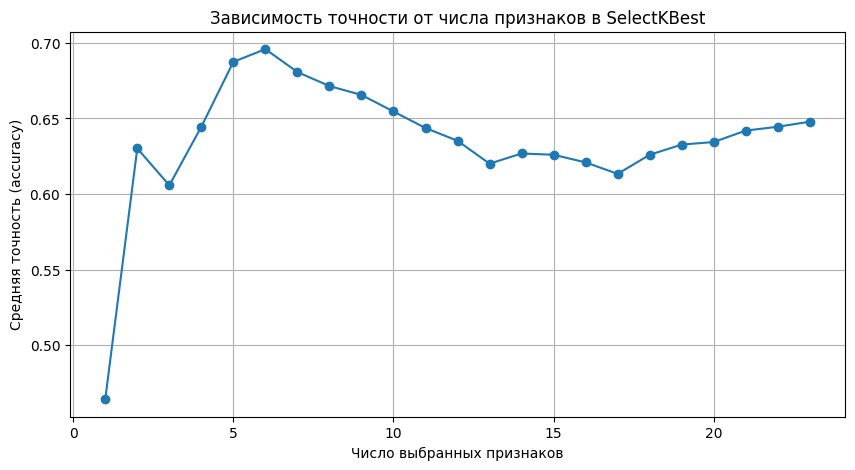

In [19]:
feature_range = range(1, len(X_train.columns)  + 1)
mean_accuracy_scores = []

for k in feature_range:
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    selected = selector.fit_transform(X_train, y_train)
    
    filtered_features = np.array(X_train.columns)[selector.get_support()]
    print(f"features - {filtered_features}")

    model = SVC(
        random_state=42,
        class_weight='balanced'
    )
    model.fit(selected, y_train)

    test_selected = selector.transform(X_test)

    y_pred = model.predict(test_selected)
    accuracy = accuracy_score(y_test, y_pred)
    mean_accuracy_scores.append(accuracy)

plt.figure(figsize=(10, 5))
plt.plot(feature_range, mean_accuracy_scores, marker='o', linestyle='-')
plt.xlabel("Число выбранных признаков")
plt.ylabel("Средняя точность (accuracy)")
plt.title("Зависимость точности от числа признаков в SelectKBest")
plt.grid(True)
plt.show()

In [ ]:
 

param_grid = {
    'C': [0.1, 0.5, 1, 2, 5, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.2, 0.5, 1],
}

model = SVC(
    random_state=42,
    class_weight='balanced',
    kernel='rbf'
)

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted' # accuracy, f1, precision, recall, totalf1
)

grid_search.fit(X_train[selected], y_train)

print("Лучшие параметры:", grid_search.best_params_)


Лучшие параметры: {'C': 10, 'gamma': 1}


In [22]:
from sklearn.metrics import classification_report, confusion_matrix

selected = ['CarCount', 'BikeCount', 'BusCount', 'Hour_cos', 'CarCount_lag1' ]

model = SVC(
    random_state=42,
    class_weight='balanced',
    C=10,
    gamma=1,
    kernel='rbf'
)
model.fit(X_train[selected], y_train)

y_pred = model.predict(X_test[selected])

print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.42      0.77      0.55       190
           1       0.90      0.55      0.68       638
           2       0.39      0.77      0.52        79
           3       0.92      0.98      0.95       280

    accuracy                           0.70      1187
   macro avg       0.66      0.77      0.67      1187
weighted avg       0.80      0.70      0.71      1187

Confusion Matrix:
[[147  30  13   0]
 [194 350  76  18]
 [  6   6  61   6]
 [  0   1   5 274]]
